In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import sys
sys.path.append('/home/guwei/envs/uc1/local/lib/python2.7/site-packages')

from keras.layers import Input, merge
from keras.models import Model,Sequential,load_model
from layers import VGGNormalize,ReflectionPadding2D,Denormalize,conv_bn_relu,res_conv,dconv_bn_nolinear
from loss import dummy_loss,StyleReconstructionRegularizer,FeatureReconstructionRegularizer,TVRegularizer
from keras.optimizers import Adam, SGD,RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from scipy.misc import imsave
import time
import numpy as np
import argparse

from keras.callbacks import TensorBoard
from scipy import ndimage

import nets
print('load done')

Using TensorFlow backend.


load done


In [3]:
import h5py

# from 6o6o's fork. https://github.com/6o6o/chainer-fast-neuralstyle/blob/master/generate.py
def original_colors(original, stylized,original_color):
    # Histogram normalization in v channel
    ratio=1. - original_color 

    hsv = color.rgb2hsv(original/255)
    hsv_s = color.rgb2hsv(stylized/255)

    hsv_s[:,:,2] = (ratio* hsv_s[:,:,2]) + (1-ratio)*hsv [:,:,2]
    img = color.hsv2rgb(hsv_s)    
    return img

def blend(original, stylized, alpha):
    return alpha * original + (1 - alpha) * stylized



def median_filter_all_colours(im_small, window_size):
    """
    Applies a median filer to all colour channels
    """
    ims = []
    for d in range(3):
        im_conv_d = median_filter(im_small[:,:,d], size=(window_size,window_size))
        ims.append(im_conv_d)

    im_conv = np.stack(ims, axis=2).astype("uint8")
    
    return im_conv

class FastNeuralStyle(object):
    def __init__(self, style_weight, content_weigth, tv_weight, style_p, img_size):
        self.style_w = style_weight
        self.content_w = content_weigth
        self.tv_w = tv_weight
        self.style_p = style_p
        self.img_size = img_size
        self.img_w, self.img_h = self.img_size

    def train(self, train_dir, nb_epoch, batch):
        # build net
        self.net = nets.image_transform_net(self.img_w, self.img_h, self.tv_w)
        self.model = nets.loss_net(self.net.output, self.net.input, self.img_w, self.img_h, self.style_p, self.content_w,
                                   self.style_w)
        
        # param
        learning_rate = 1e-3  # 1e-3
        optimizer = Adam(lr=learning_rate)  # Adam(lr=learning_rate,beta_1=0.99)

        self.model.compile(optimizer, dummy_loss)  # Dummy loss since we are learning from regularizes
        dummy_y = np.zeros((batch, self.img_w, self.img_h, 3))  # Dummy output, not used since we use regularizers to train
        datagen = ImageDataGenerator()

        # start train
        i = 0
        t1 = time.time()
        for x in datagen.flow_from_directory(train_dir, class_mode=None, batch_size=batch,
                                             target_size=(self.img_w, self.img_h), shuffle=False):
            if i > nb_epoch:
                break

            i += 1

            hist = self.model.train_on_batch(x, dummy_y)

            if i % 50 == 0:
                print(hist, (time.time() - t1))
                t1 = time.time()

            # check
            if i % 500 == 0:
                print("epoc: ", i)
                val_x = self.net.predict(x)
                print(val_x.shape,x.shape)
                imsave('{}_res.png'.format(i),val_x[0])
                imsave('{}_res_org.png'.format(i), x[0])
                self.model.save_weights('nn_weights.h5')
    
    def load_w(self,file_path):
        # set net
        self.net = nets.image_transform_net(self.img_w, self.img_h, 1)
        self.model = nets.loss_net(self.net.output, self.net.input, self.img_w, self.img_h, '', 0,0)
        self.model.summary()
        self.model.compile(Adam(),dummy_loss)
        self.model.load_weights(file_path)
        print('Pretrained Model weights loaded.')
    

nn = FastNeuralStyle(style_weight=4.0,content_weigth=1.0,tv_weight=1,style_p='',img_size=(256,256))
nn.load_w('nn_weights.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
input_normalize_1 (InputNormali (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
reflection_padding2d_1 (Reflect (None, 336, 336, 3)  0           input_normalize_1[0][0]          
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 336, 336, 32) 7808        reflection_padding2d_1[0][0]     
__________________________________________________________________________________________________
batch_norm

Pretrained Model weights loaded.


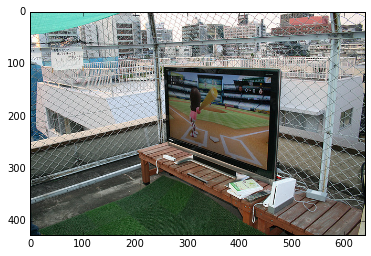

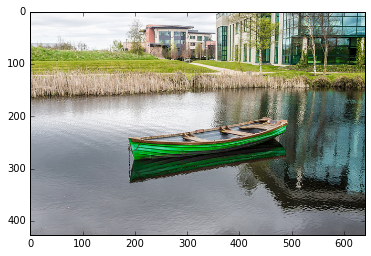

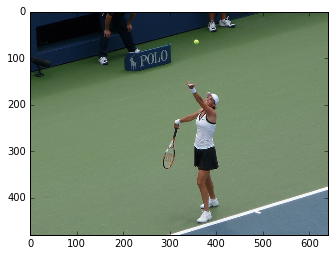

In [4]:
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy.misc import imsave,imread,imresize
import cv2

%matplotlib inline
fl = list(glob.glob('./data/content/*'))[:10]
for f in fl[:3]:
    x = imread(f,mode='RGB')
    plt.figure()
    plt.imshow(x)
    plt.show()


In [5]:
from scipy.ndimage.filters import median_filter
from skimage import color, exposure, transform
def original_colors(original, stylized,original_color):
    # Histogram normalization in v channel
    ratio= 1. - original_color 

    hsv = color.rgb2hsv(original/255)
    hsv_s = color.rgb2hsv(stylized/255)

    hsv_s[:,:,2] = (ratio* hsv_s[:,:,2]) + (1-ratio)*hsv [:,:,2]
    img = color.hsv2rgb(hsv_s)    
    return img

def blend(original, stylized, alpha):
    res = alpha * original + (1 - alpha) * stylized
    return np.clip(res,0,255).astype(np.uint8)

def median_filter_all_colours(im_small, window_size):
    """
    Applies a median filer to all colour channels
    """
    ims = []
    for d in range(3):
        im_conv_d = median_filter(im_small[:,:,d], size=(window_size,window_size))
        ims.append(im_conv_d)

    im_conv = np.stack(ims, axis=2).astype("uint8")
    
    return im_conv

/home/fluke/envs/uc/local/lib/python2.7/site-packages/scipy/misc/pilutil.py:480: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/home/fluke/envs/uc/local/lib/python2.7/site-packages/scipy/misc/pilutil.py:483: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


(1, 254, dtype('uint8'), dtype('uint8'), 255)


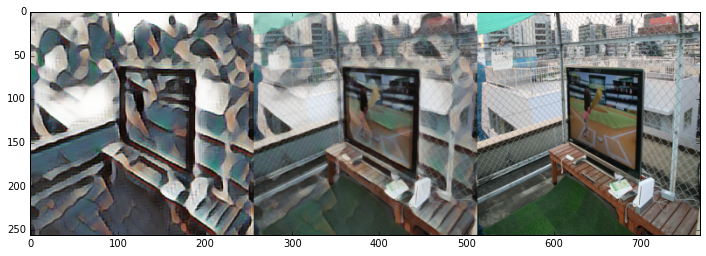

-----------------
(0, 254, dtype('uint8'), dtype('uint8'), 253)


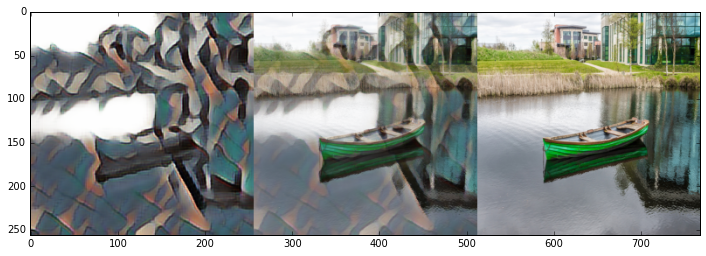

-----------------
(0, 241, dtype('uint8'), dtype('uint8'), 252)


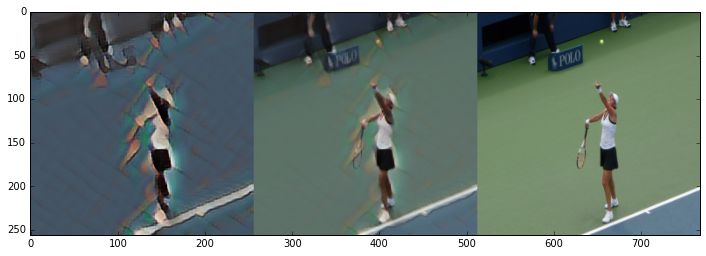

-----------------
(1, 254, dtype('uint8'), dtype('uint8'), 255)


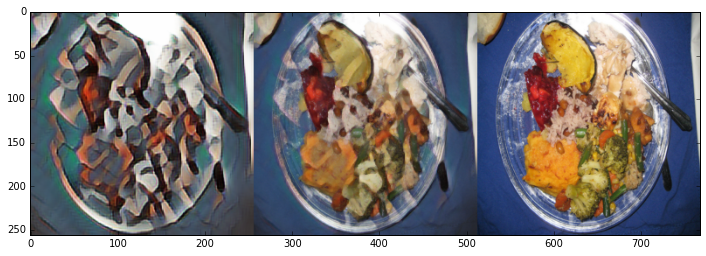

-----------------
(2, 253, dtype('uint8'), dtype('uint8'), 255)


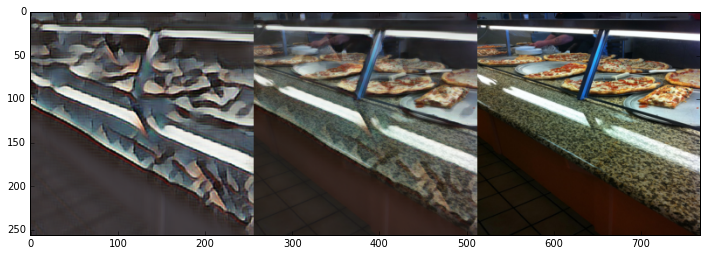

-----------------
(0, 254, dtype('uint8'), dtype('uint8'), 245)


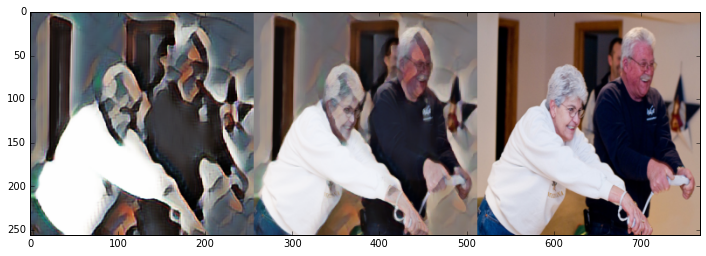

-----------------
(0, 253, dtype('uint8'), dtype('uint8'), 255)


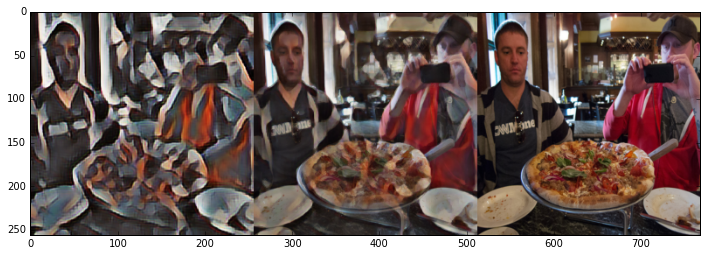

-----------------
(0, 254, dtype('uint8'), dtype('uint8'), 255)


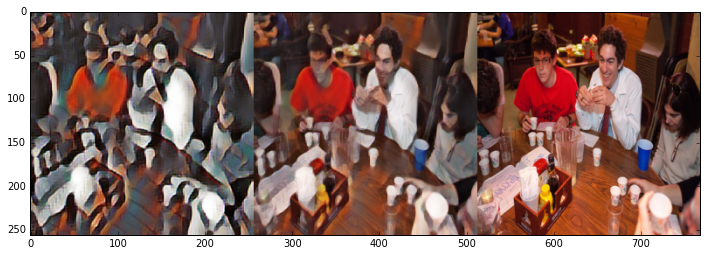

-----------------
(0, 255, dtype('uint8'), dtype('uint8'), 255)


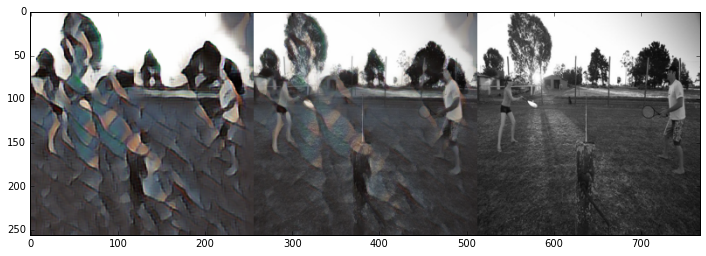

-----------------
(7, 254, dtype('uint8'), dtype('uint8'), 239)


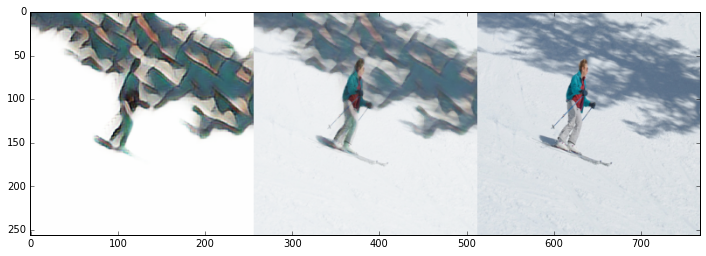

-----------------


In [6]:
i = 0 
for f in fl:
    x = imread(f,mode='RGB')
    x = np.array([imresize(x,(256,256))])
    y = nn.net.predict(x)[0].astype(np.uint8)
    print(np.min(y),np.max(y),y.dtype,x.dtype,np.max(x))
    
    # update  y
    update_y = y.copy()
    update_y = median_filter_all_colours(update_y,3) # default 3
    blend_alpha = 0.5
    update_y = blend(x[0],update_y,blend_alpha)
    
    
    # show and save
    plt.figure(figsize=(12,4))
    comb_img = np.concatenate((y,update_y,x[0]),1)
    plt.imshow(comb_img)
    plt.show()
    imsave('./data/output/val_{}.png'.format(i),y)
    i += 1
    print('-----------------')